# LangSmith and Evaluation Overview with AI Makerspace

Today we'll be looking at an amazing tool:

[LangSmith](https://docs.smith.langchain.com/)!

This tool will help us monitor, test, debug, and evaluate our LangChain applications - and more!

We'll also be looking at a few Advanced Retrieval techniques along the way - and evaluate it using LangSmith!

✋BREAKOUT ROOM #2:
- Task 1: Dependencies and OpenAI API Key
- Task 2: LangGraph RAG
- Task 3: Setting Up LangSmith
- Task 4: Examining the Trace in LangSmith!
- Task 5: Create Testing Dataset
- Task 6: Evaluation

## Task 1: Dependencies and OpenAI API Key

We'll be using OpenAI's suite of models today to help us generate and embed our documents for our simple RAG system that leverages Loand Complaint data.

In [1]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

#### Asyncio Bug Handling

In [2]:
import nest_asyncio
nest_asyncio.apply()

## Task #2: Create a Simple RAG Application Using LangGraph

Let's remake our LangGraph RAG pipeline from the first notebook!

## LangGraph Powered RAG

First and foremost, LangChain provides a convenient way to store our chunks and their embeddings.

It's called a `VectorStore`!

We'll be using QDrant as our `VectorStore` today. You can read more about it [here](https://qdrant.tech/documentation/).

Think of a `VectorStore` as a smart way to house your chunks and their associated embedding vectors. The implementation of the `VectorStore` also allows for smarter and more efficient search of our embedding vectors - as the method we used above would not scale well as we got into the millions of chunks.

Otherwise, the process remains relatively similar under the hood!

### Data Collection

We'll be leveraging the `DirectoryLoader` to load our PDFs!

In [3]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyMuPDFLoader

directory_loader = DirectoryLoader("data", glob="**/*.pdf", loader_cls=PyMuPDFLoader)

jr_document = directory_loader.load()

jr_document[5].page_content

'“Then destroy them!”\xa0rejoined Simoun coldly.  \n“And the money to pay the laborers?”  \n“Don’t pay them! Use the prisoners and convicts!”  \n“But there aren’t\xa0enough,\xa0Señor\xa0Simoun!”  \n“Then, if there aren’t enough, let all the villagers, the old men, the youths, the boys, work. Instead of the fifteen days \nof obligatory service, let them work three, four, five months for the State, with the additional obligation that each one \nprovide his own food and tools.”  \nThe startled Don Custodio turned his head to see if there was any Indian within ear-shot, but fortunately those \nnearby were rustics, and the two helmsmen seemed to be very much occupied with the windings of the river.  \n“But,\xa0Señor\xa0Simoun—”  \n“Don’t fool yourself, Don Custodio,”\xa0continued Simoun dryly, “only in this way are great enterprises carried out \nwith small means. Thus were constructed the Pyramids, Lake Moeris, and the Colosseum in Rome. Entire provinces \ncame in from the desert, bringing

### Chunking Our Documents

Let's do the same process as we did before with our `RecursiveCharacterTextSplitter` - but this time we'll use ~200 tokens as our max chunk size!

In [4]:
import tiktoken
from langchain.text_splitter import RecursiveCharacterTextSplitter

def tiktoken_len(text):
    tokens = tiktoken.encoding_for_model("gpt-4o").encode(
        text,
    )
    return len(tokens)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 750,
    chunk_overlap = 0,
    length_function = tiktoken_len,
)
jose_rizal_chunks = text_splitter.split_documents(jr_document)

In [5]:
len(jose_rizal_chunks)

812

Let's verify the process worked as intended by checking our max document length.

In [6]:
max_chunk_length = 0

for chunk in jose_rizal_chunks:
  max_chunk_length = max(max_chunk_length, tiktoken_len(chunk.page_content))

print(max_chunk_length)

722


Perfect! Now we can carry on to creating and storing our embeddings.

### Embeddings and Vector Storage

We'll use the `text-embedding-3-small` embedding model again - and `Qdrant` to store all our embedding vectors for easy retrieval later!

In [7]:
from langchain_community.vectorstores import Qdrant
from langchain_openai.embeddings import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

qdrant_vectorstore = Qdrant.from_documents(
    documents=jose_rizal_chunks,
    embedding=embedding_model,
    location=":memory:"
)

Now let's set up our retriever, just as we saw before, but this time using LangChain's simple `as_retriever()` method!

In [8]:
qdrant_retriever = qdrant_vectorstore.as_retriever()

#### Back to the Flow

We're ready to move to the next step!

### Setting up our RAG

We'll use the same LangGraph pipeline we created in the first notebook. 

Let's think through each part:

1. First we need to retrieve context
2. We need to pipe that context to our model
3. We need to parse that output

Let's start by setting up our prompt again, just so it's fresh in our minds!

Complete the prompt so that your RAG application answers queries based on the context provided, but *does not* answer queries if the context is unrelated to the query.

In [32]:
from langchain_core.prompts import ChatPromptTemplate

HUMAN_TEMPLATE = """


#CONTEXT:
{context}

QUERY:
{query}

"""



HUMAN_TEMPLATE_FIXED = """
Use the provide context to answer the provided user query. Only use the provided context to answer the query. 
If you do not know the answer, or it's not contained in the provided context respond with "I don't know"

#CONTEXT:
{context}

QUERY:
{query}

"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("human", HUMAN_TEMPLATE)
])

chat_prompt_fixed = ChatPromptTemplate.from_messages([
    ("human", HUMAN_TEMPLATE_FIXED)
])

We'll set our Generator - `gpt-4.1-nano` in this case - below!

In [33]:
from langchain_openai import ChatOpenAI

openai_chat_model = ChatOpenAI(model="gpt-4o-mini")

#### Our RAG Application

Let's spin up the graph.

In [34]:
from langgraph.graph import START, StateGraph
from typing_extensions import TypedDict
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser

class State(TypedDict):
  question: str
  context: list[Document]
  response: str

def retrieve(state: State) -> State:
  retrieved_docs = qdrant_retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

def generate(state: State) -> State:
  generator_chain = chat_prompt | openai_chat_model | StrOutputParser()
  response = generator_chain.invoke({"query" : state["question"], "context" : state["context"]})
  return {"response" : response}

def generate_fixed(state: State) -> State:
  generator_chain = chat_prompt_fixed | openai_chat_model | StrOutputParser()
  response = generator_chain.invoke({"query" : state["question"], "context" : state["context"]})
  return {"response" : response}

In [35]:
graph_builder = StateGraph(State)
graph_builder = graph_builder.add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
rag_graph = graph_builder.compile()

In [36]:
graph_builder_fixed = StateGraph(State)
graph_builder_fixed = graph_builder_fixed.add_sequence([retrieve, generate_fixed])
graph_builder_fixed.add_edge(START, "retrieve")
rag_graph_fixed = graph_builder_fixed.compile()

Let's get a visual understanding of our chain!

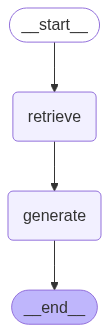

In [37]:
rag_graph

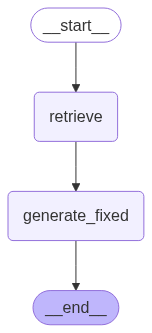

In [38]:
rag_graph_fixed

Let's test our chain out!

In [31]:
#---- Original Code - Response
response = rag_graph.invoke({"question" : "When did the Philippines gain independence?"})
response["response"]

'The Philippines gained independence from the United States on July 4, 1946.'

In [39]:
#---- Fixed - Response
response_fixed = rag_graph_fixed.invoke({"question" : "When did the Philippines gain independence?"})
response_fixed["response"]

"I don't know."

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

### 🎯 Breakout Room - Group Discussion: 

Why did the model answer the question even when its not related to writings of Dr. Jose Rizal?

How can you improve the prompt to respond only within the context?  
</div>

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

### Observations :

* The model answered the questions because LangChain doesn't automatically format documents for prompts, so models fall back on its foundational/pretrained knowledged. 

* To improve the prompt response only within the context we need to format the context properly and make the prompt instruction explicit if there are no actual context to be fetch. To fix it, please enable below code in the HUMAN_TEMPLATE. 

```python
"""
Use the provide context to answer the provided user query. Only use the provided context to answer the query. 
If you do not know the answer, or it's not contained in the provided context respond with "I don't know"
"""
```

By formatting the context properly and making the prompt instruction explicit, you create a true RAG pipeline that obeys context only constraints.
</span>


## Task 3: Setting Up LangSmith (Extra! Extra!)

Now that we have a chain - we're ready to get started with LangSmith!

Create a Langsmith account here(https://smith.langchain.com/) and Setup your API key.

We're going to go ahead and use the following `env` variables to get our notebook set up to start reporting.

If all you needed was simple monitoring - this is all you would need to do!

In [40]:
from uuid import uuid4
import os
from getpass import getpass

PROJECT_NAME = f"PSI AI Eng - DAY_3 - {uuid4().hex[0:8]}"

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = PROJECT_NAME

In [43]:
print(PROJECT_NAME)

PSI AI Eng - DAY_3 - 77c22e68


### LangSmith API

In order to use LangSmith - you will need an API key. You can sign up for a free account on [LangSmith's homepage!](https://www.langchain.com/langsmith)

Once you have created your account, Take the navigation option for `Settings` then `API Keys` to create an API key.

In [41]:
from langchain.callbacks import LangChainTracer

os.environ["LANGSMITH_API_KEY"] = getpass('Enter your LangSmith API key: ')

tracer = LangChainTracer()  
tracer.project_name = PROJECT_NAME

Let's test our our first generation!

In [42]:
result = rag_graph_fixed.invoke(
    {"question": "Who is Capitan Tiago?"},
    config={"tags": ["Demo Run"], "callbacks": [tracer]}
)

print("\nResponse:\n", result['response'])
print("\nTracing Project name:", tracer.project_name)



Response:
 Capitan Tiago, whose full name is Don Santiago de los Santos, is depicted as a low-statured, corpulent man with a clear complexion, who appears younger than his actual age, estimated to be between thirty and thirty-five years. He is characterized by a sanctified look, small eyes, a slender nose, and a mouth disfigured by the use of tobacco and buyo. He is considered one of the richest landlords in Binondo and an important planter due to his estates in Pampanga. Capitan Tiago is known for his hospitality and is a central character in the narrative, highlighting the social dynamics of his time.

Tracing Project name: PSI AI Eng - DAY_3 - 77c22e68


## Task 4: Examining the Trace in LangSmith!

Head on over to your LangSmith web UI to check out how the trace looks in LangSmith!

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

#### 🏗️ Activity #1:

Include a screenshot of your trace and explain what it means.
</div>

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

### Observations :

Please see below trace details: 

**Project Name: PSI AI Eng - DAY_3 - 77c22e68

*Start Time: 08/08/2025, 10:49:03 AM - When was the pipeline started

*End Time: 08/08/2025, 10:49:08 AM - When was the pipeline ended

*Status: Success - This explains that the pipeline is successful

*Total tokens: 2,708 tokens / $0.0004647 - This explains the total tokens used by OpenAI

*Latency: 4.87s - This show the latency

*Type: Chain

*Retrieve (1.90s): The system first went to it's vector database and searched for anything about "Capitan Tiago." It found a few relevant pages. This step took about 2 seconds. 

*Generate (2.72s): Next, the system read those pages and wrote a summary to answer your question. This step took about 2.7 seconds.

*Final Answer: The result is the complete description of Capitan Tiago you see at the bottom

*Screenshots:
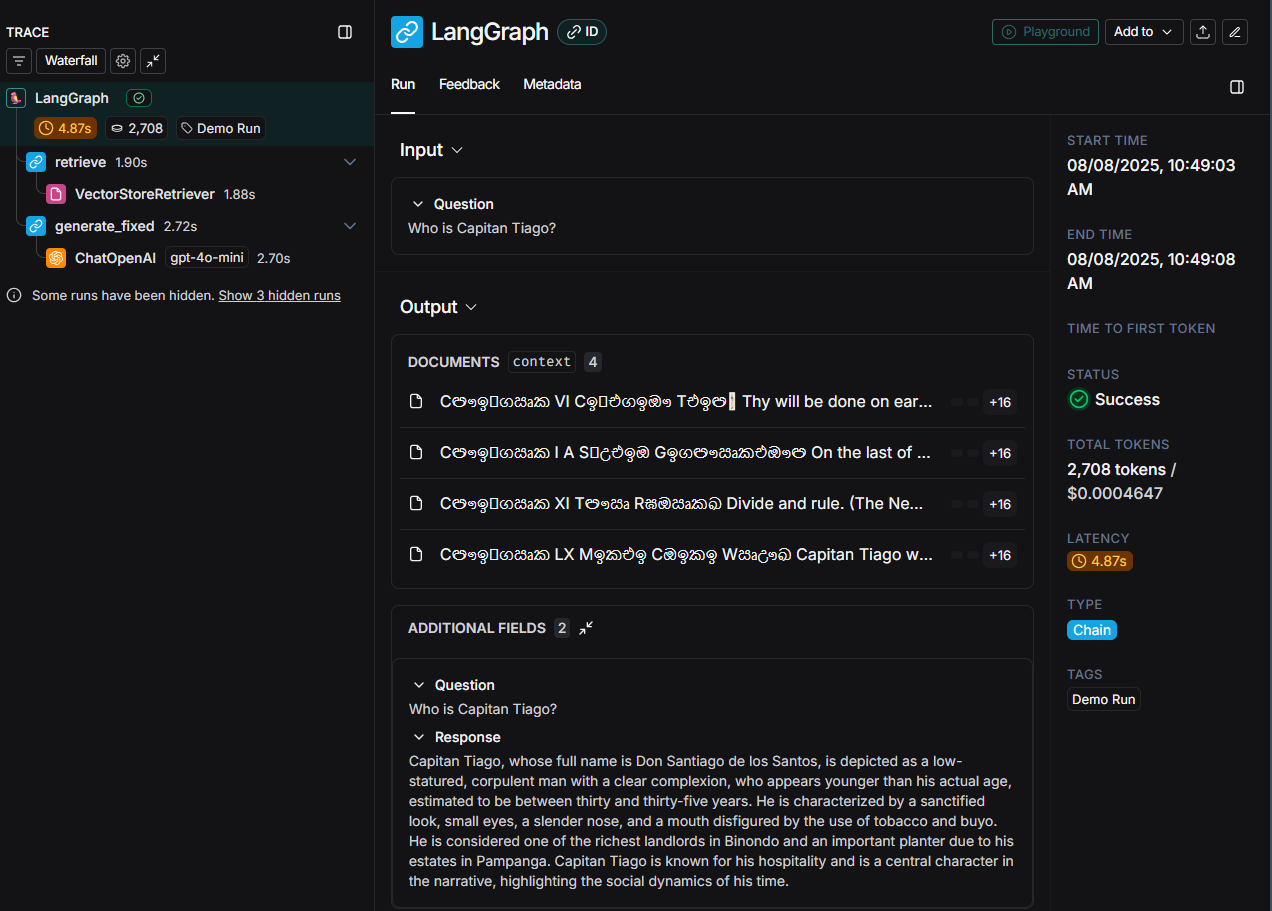



*The LangSmith trace provides a detailed, step-by-step breakdown of how our RAG LLM pipeline works by processesing an input, finds relevant information, and generates a coherent response. This trace will answer these questions:

- What was asked?
- What steps the AI took to find the answer?
- How long each step took?
- What the final answer was?

</span>
